In [1]:
# Stacked Regressions : Top 4% on LeaderBoard

https://www.kaggle.com/code/serigne/stacked-regressions-top-4-on-leaderboard

In [303]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
color = sns.color_palette()
sns.set_style('darkgrid')

import tensorflow as tf
import tensorflow_decision_forests as tfdf

from scipy import stats
from scipy.stats import norm, skew
from sklearn.preprocessing import LabelEncoder

from subprocess import check_output
# print(check_output(['ls', '../input']))

pd.set_option('display.float_format', lambda x: '{:.3f}'.format(x))

import warnings
warnings.filterwarnings('ignore')

In [304]:
train_df = pd.read_csv('./train.csv')
test_df = pd.read_csv('./test.csv')

print(f'train_df.shape = {train_df.shape}')
print(f'test_df.shape = {test_df.shape}')

train_df.shape = (1460, 81)
test_df.shape = (1459, 80)


In [305]:
train_id = train_df['Id']
test_id = test_df['Id']

train_df.drop('Id', axis = 1, inplace = True)
test_df.drop('Id', axis = 1, inplace = True)

### Outlier

산점도를 보고 경향에서 튀어나온 데이터에 대해서 아웃라이어 처리를 진행

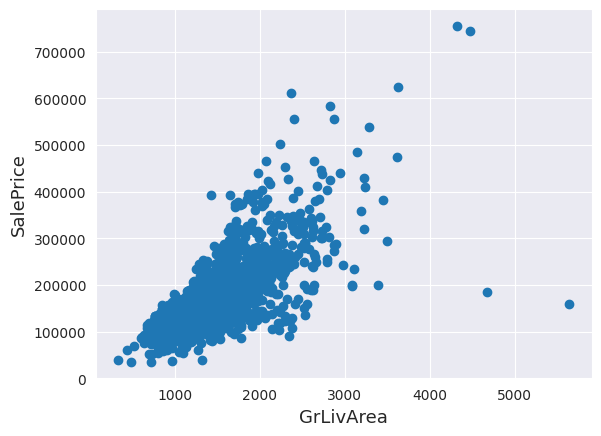

In [306]:
fig, ax = plt.subplots()

ax.scatter(x = train_df['GrLivArea'],
           y = train_df['SalePrice'])
plt.ylabel('SalePrice', fontsize = 13)
plt.xlabel('GrLivArea', fontsize = 13)

plt.show()

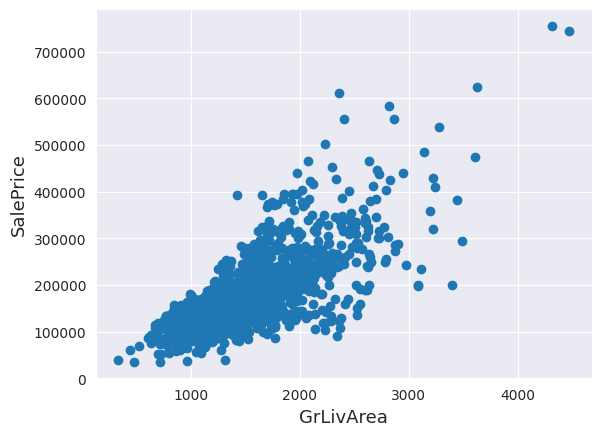

In [307]:
train_df = train_df.drop(train_df.loc[
                                        (train_df['GrLivArea'] > 4000) &
                                        (train_df['SalePrice'] < 300000)
                                    ].index)

fig, ax = plt.subplots()

ax.scatter(x = train_df['GrLivArea'],
           y = train_df['SalePrice'])
plt.ylabel('SalePrice', fontsize = 13)
plt.xlabel('GrLivArea', fontsize = 13)

plt.show()

### Label 값의 분포 확인


 mu = 180932.92 and sigma = 79467.79



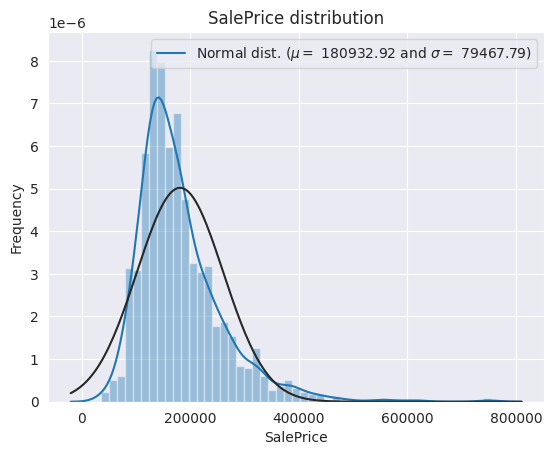

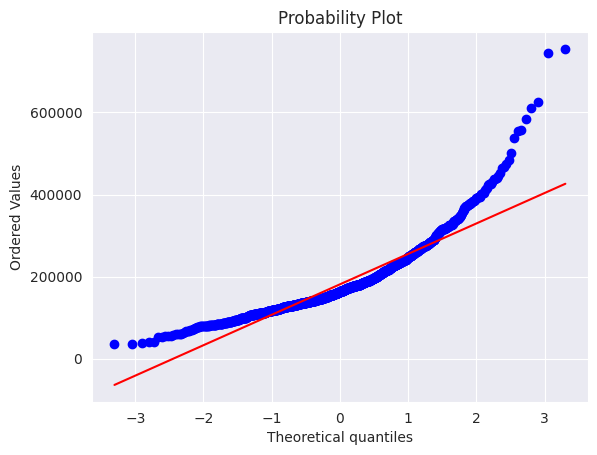

In [308]:
sns.distplot(train_df['SalePrice'], fit = norm)

(mu, sigma) = norm.fit(train_df['SalePrice'])
print('\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))

plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f})'.format(mu, sigma)],
           loc = 'best')
plt.ylabel('Frequency')
plt.title('SalePrice distribution')

fig = plt.figure()
res = stats.probplot(train_df['SalePrice'], plot = plt)
plt.show()

### 분포에 대한 로그 변환

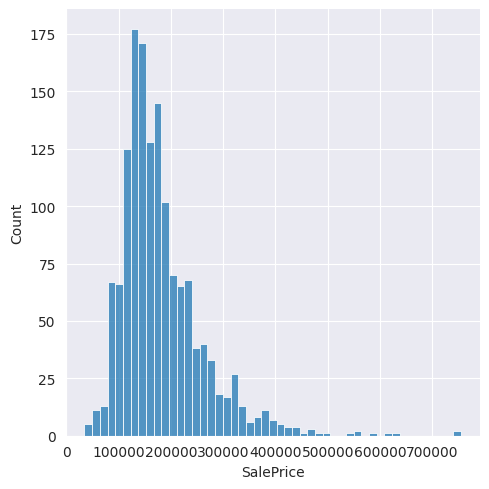

In [309]:
sns.displot(train_df['SalePrice'])

<Axes: xlabel='SalePrice', ylabel='Density'>

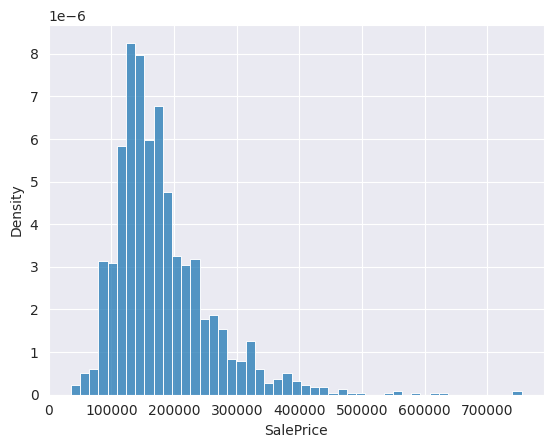

In [310]:
sns.histplot(train_df['SalePrice'],
             stat = 'density')


 mu = 12.02 and sigma = 0.40



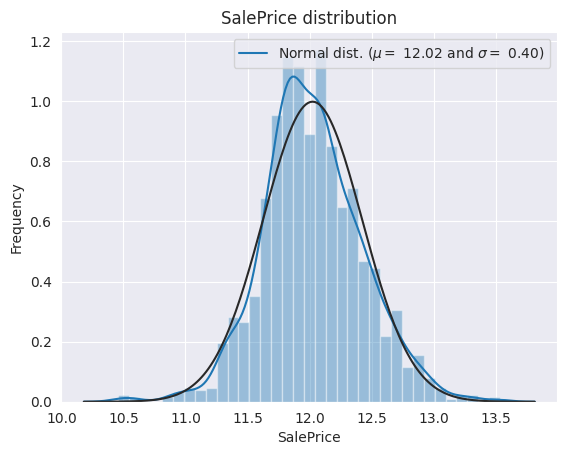

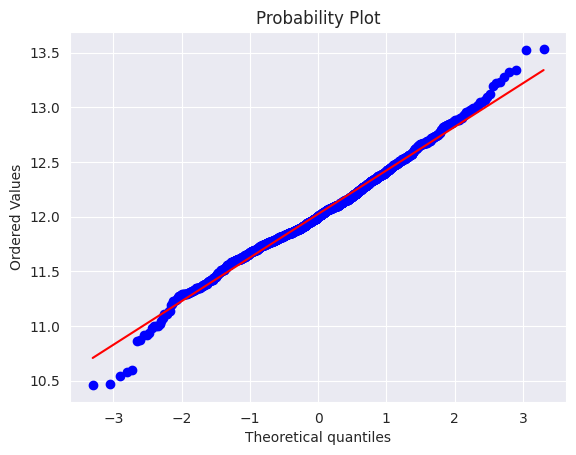

In [311]:
# log transformation

train_df['SalePrice'] = np.log1p(train_df['SalePrice'])

sns.distplot(train_df['SalePrice'], fit = norm)

(mu, sigma) = norm.fit(train_df['SalePrice'])
print('\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))

plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f})'.format(mu, sigma)],
           loc = 'best')
plt.ylabel('Frequency')
plt.title('SalePrice distribution')

fig = plt.figure()
res = stats.probplot(train_df['SalePrice'], plot = plt)
plt.show()

### Feature Engineering

In [312]:
n_train = train_df.shape[0]
n_test = test_df.shape[0]

y_train = train_df['SalePrice'].values
all_df = pd.concat([train_df, test_df]).reset_index(drop = True)
all_df.drop(['SalePrice'], axis = 1, inplace = True)

print('all_df size is : {}'.format(all_df.shape))

all_df size is : (2917, 79)


In [313]:
# missing data

all_df_na = (all_df.isnull().sum() / len(all_df)) * 100
all_df_na = all_df_na.drop(all_df_na.loc[all_df_na == 0].index).sort_values(ascending = False)[:30]

missing_df = pd.DataFrame({'Missing Ratio': all_df_na})
display(missing_df[:20])

,Missing Ratio
PoolQC,99.691
MiscFeature,96.400
Alley,93.212
Fence,80.425
FireplaceQu,48.680
LotFrontage,16.661
GarageFinish,5.451
GarageQual,5.451
GarageCond,5.451
GarageYrBlt,5.451


Text(0.5, 1.0, 'Percent missing data by feature')

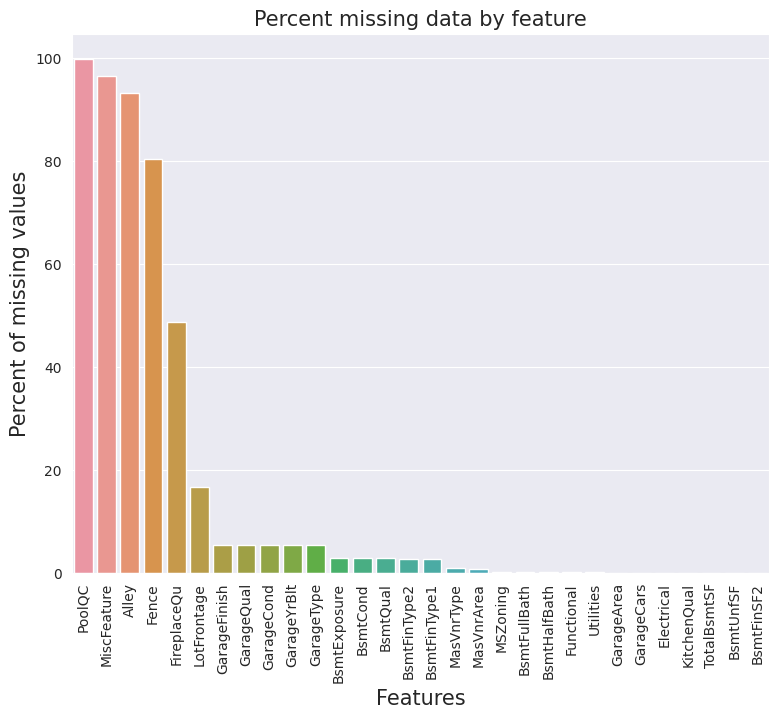

In [315]:
fig, ax = plt.subplots(figsize = (9, 7))

plt.xticks(rotation = 90)
sns.barplot(x = all_df_na.index,
            y = all_df_na)
plt.xlabel('Features', fontsize = 15)
plt.ylabel('Percent of missing values', fontsize = 15)
plt.title('Percent missing data by feature', fontsize = 15)

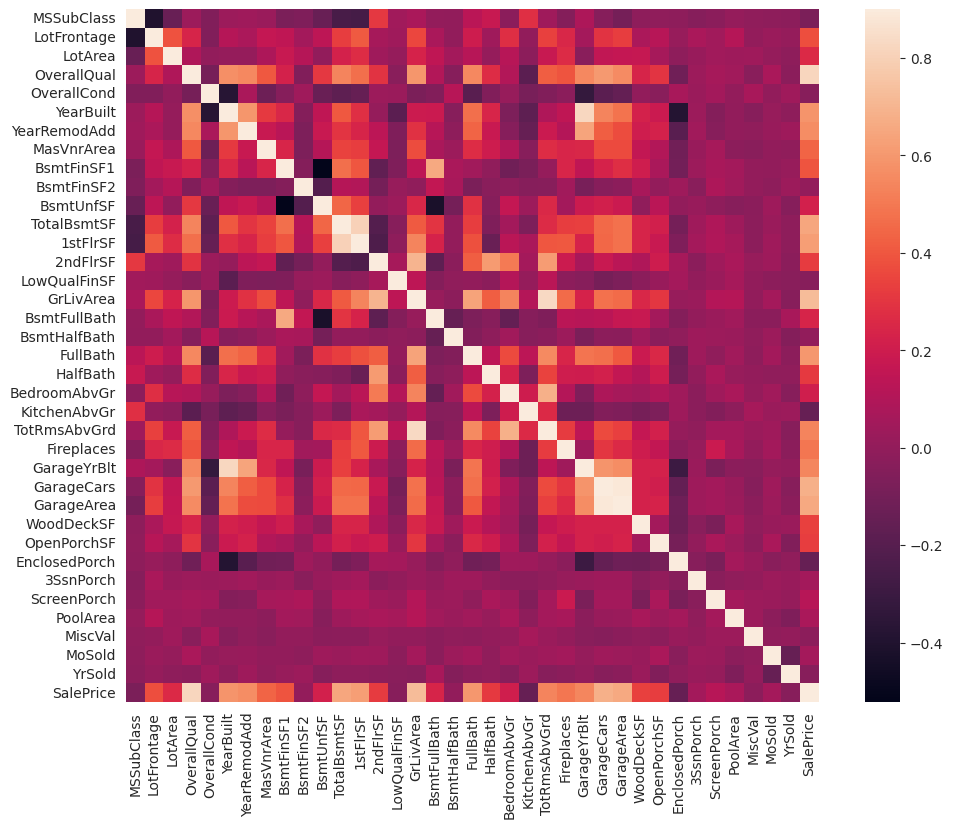

In [318]:
# Correlation Matrix
corrmat = train_df.corr()

plt.subplots(figsize = (12, 9))
sns.heatmap(corrmat, vmax = 0.9, square = True)

plt.show()

### Null 값 처리

In [319]:
# PoolQC (str type)
all_df['PoolQC'] = all_df['PoolQC'].fillna('None')

# MiscFeature
all_df['MiscFeature'] = all_df['MiscFeature'].fillna('None')

# Alley
all_df['Alley'] = all_df['Alley'].fillna('None')

# Fence
all_df['Fence'] = all_df['Fence'].fillna('None')

# FireplaceQu
all_df['FireplaceQu'] = all_df['FireplaceQu'].fillna('None')

In [320]:
# LotFrontage (float64) - 어떤 방법으로 빈 값을 채울 것인가?
all_df['LotFrontage'] = all_df.groupby(['Neighborhood'])['LotFrontage'].transform(lambda x: x.fillna(x.median()))

In [321]:
for col in ('GarageType', 'GarageFinish', 'GarageQual', 'GarageCond'):
    all_df[col] = all_df[col].fillna('None')
    
for col in ('GarageYrBlt', 'GarageArea', 'GarageCars'):
    all_df[col] = all_df[col].fillna(0)
    
for col in ('BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath'):
    all_df[col] = all_df[col].fillna(0)
    
for col in ('BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2'):
    all_df[col] = all_df[col].fillna('None')

In [322]:
all_df['MasVnrType'] = all_df['MasVnrType'].fillna('None')
all_df['MasVnrArea'] = all_df['MasVnrArea'].fillna(0)

In [323]:
all_df['MSZoning'] = all_df['MSZoning'].fillna(all_df['MSZoning'].mode()[0])

In [324]:
# 값이 별로 없는 컬럼의 경우, 학습에 전혀 도움이 되지 않으므로 해당 컬럼은 삭제
all_df = all_df.drop(['Utilities'], axis = 1)

In [325]:
all_df['Functional'] = all_df['Functional'].fillna('Typ')

all_df['Electrical'] = all_df['Electrical'].fillna(all_df['Electrical'].mode()[0])

all_df['KitchenQual'] = all_df['KitchenQual'].fillna(all_df['KitchenQual'].mode()[0])

all_df['Exterior1st'] = all_df['Exterior1st'].fillna(all_df['Exterior1st'].mode()[0])
all_df['Exterior2nd'] = all_df['Exterior2nd'].fillna(all_df['Exterior2nd'].mode()[0])

all_df['SaleType'] = all_df['SaleType'].fillna(all_df['SaleType'].mode()[0])

all_df['MSSubClass'] = all_df['MSSubClass'].fillna('None')

In [326]:
all_df_na = (all_df.isnull().sum() / len(all_df)) * 100
all_df_na = all_df_na.drop(all_df_na[all_df_na == 0].index).sort_values(ascending = False)

missing_data = pd.DataFrame({'Missing Ratio': all_df_na})
display(missing_data.head())

,Missing Ratio


### Next Step

In [327]:
all_df['MSSubClass'] = all_df['MSSubClass'].apply(str) # 왜 스트링으로?

all_df['OverallCond'] = all_df['OverallCond'].astype(str)

all_df['YrSold'] = all_df['YrSold'].astype(str)
all_df['MoSold'] = all_df['MoSold'].astype(str)

In [328]:
# Label Encoding
from sklearn.preprocessing import LabelEncoder

cols = ('FireplaceQu', 'BsmtQual', 'BsmtCond', 'GarageQual', 'GarageCond', 
        'ExterQual', 'ExterCond','HeatingQC', 'PoolQC', 'KitchenQual', 'BsmtFinType1', 
        'BsmtFinType2', 'Functional', 'Fence', 'BsmtExposure', 'GarageFinish', 'LandSlope',
        'LotShape', 'PavedDrive', 'Street', 'Alley', 'CentralAir', 'MSSubClass', 'OverallCond', 
        'YrSold', 'MoSold')

print('Before: Shape all_df: {}'.format(all_df.shape))

for c in cols:
    lbl = LabelEncoder()
    lbl.fit(list(all_df[c].values))
    all_df[c] = lbl.transform(list(all_df[c].values))
    
print('After: Shape all_df: {}'.format(all_df.shape))

Before: Shape all_df: (2917, 78)
After: Shape all_df: (2917, 78)


In [329]:
all_df['TotalSF'] = all_df['TotalBsmtSF'] + all_df['1stFlrSF'] + all_df['2ndFlrSF']

In [331]:
# Skew(왜도) 데이터의 분포가 얼마나 비대칭인지 확인하기 위함

numeric_feats = all_df.dtypes[all_df.dtypes != 'object'].index

skewed_feats = all_df[numeric_feats].apply(lambda x: skew(x.dropna())).sort_values(ascending = False)
print('Skew in numerical features: \n')

skewness = pd.DataFrame({'Skew': skewed_feats})
display(skewness.head(5))

Skew in numerical features: 



,Skew
MiscVal,21.940
PoolArea,17.689
LotArea,13.109
LowQualFinSF,12.085
3SsnPorch,11.372


- Box-Cox Transformation

선형 회귀 분석의 베이스는 변수가 정규 분포를 따른다는 가정.

but, 많은 데이터들이 정규 분포를 따르지 않는다. 이 경우에 우리는 데이터에 변환을 주어 정규 분포를 따르도록 시도해볼 수 있는데,

box-cox 변환 또한 이러한 시도 중 하나이다.

In [332]:
skewness = skewness[abs(skewness) > 0.75] # 왜도가 0.75이상인 데이터에 대해서만 변환을 할 계획
# 왜도 갑이 크다 -> 데이터의 비대칭성이 크다

from scipy.special import boxcox1p

skewed_features = skewness.index
lam = 0.15

for feat in skewed_features:
    all_df[feat] = boxcox1p(all_df[feat], lam)

In [333]:
skewed_features

Index(['MiscVal', 'PoolArea', 'LotArea', 'LowQualFinSF', '3SsnPorch',
       'LandSlope', 'KitchenAbvGr', 'BsmtFinSF2', 'EnclosedPorch',
       'ScreenPorch', 'BsmtHalfBath', 'MasVnrArea', 'OpenPorchSF',
       'WoodDeckSF', '1stFlrSF', 'LotFrontage', 'GrLivArea', 'TotalSF',
       'BsmtFinSF1', 'BsmtUnfSF', '2ndFlrSF', 'TotRmsAbvGrd', 'Fireplaces',
       'HalfBath', 'TotalBsmtSF', 'BsmtFullBath', 'OverallCond', 'HeatingQC',
       'FireplaceQu', 'BedroomAbvGr', 'GarageArea', 'OverallQual', 'FullBath',
       'MSSubClass', 'YrSold', 'BsmtFinType1', 'GarageCars', 'YearRemodAdd',
       'BsmtQual', 'YearBuilt', 'GarageFinish', 'LotShape', 'MoSold', 'Alley',
       'BsmtExposure', 'KitchenQual', 'ExterQual', 'Fence', 'ExterCond',
       'BsmtCond', 'PavedDrive', 'BsmtFinType2', 'GarageQual', 'CentralAir',
       'GarageCond', 'GarageYrBlt', 'Functional', 'Street', 'PoolQC'],
      dtype='object')

In [334]:
print(all_df.shape)

# one-hot encoding
all_df = pd.get_dummies(all_df)
print(all_df.shape)

(2917, 79)
(2917, 220)


In [353]:
train_df = all_df[:n_train]
test_df = all_df[n_train:]

X_train = train_df.values

# Modeling

In [337]:
from sklearn.linear_model import ElasticNet, Lasso, BayesianRidge, LassoLarsIC
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.metrics import mean_squared_error

import xgboost as xgb
import lightgbm as lgb

In [354]:
n_folds = 5

# cv - cross validation
def rmsle_cv(model):
    kf = KFold(n_folds, shuffle = True, random_state = 42).get_n_splits(X_train)
    
    rmse = np.sqrt(-cross_val_score(model,
                                    X_train,
                                    y_train,
                                    scoring = 'neg_mean_squared_error',
                                    cv = kf))
    
    return rmse

### Base model

In [355]:
# Lasso Regression
lasso = make_pipeline(RobustScaler(),
                      Lasso(alpha = 0.0005, random_state = 1))

In [356]:
# Elastic Net Regression
ENet = make_pipeline(RobustScaler(),
                     ElasticNet(alpha = 0.0005, l1_ratio = 0.9, random_state = 3))

In [357]:
# Kernel Ridge Regression
KRR = KernelRidge(alpha = 0.6, kernel = 'polynomial', degree = 2, coef0 = 2.5)

In [358]:
# Gradient Boosting Regression
GBoost = GradientBoostingRegressor(n_estimators = 3000,
                                   learning_rate = 0.05,
                                   max_depth = 4,
                                   max_features = 'sqrt',
                                   min_samples_leaf = 15,
                                   min_samples_split = 10,
                                   loss = 'huber',
                                   random_state = 5)

In [359]:
# XGBoost - 하이퍼 파라미터 값들은 어떻게 결정된 것인가?
model_xgb = xgb.XGBRegressor(colsample_bytree = 0.4603,
                             gamma = 0.0468,
                             learning_rate = 0.05,
                             max_depth = 3,
                             min_child_weight = 1.7817,
                             n_estimator = 2200,
                             reg_alpha = 0.4640,
                             reg_lambda = 0.8571,
                             subsample = 0.5213,
                             silent = 1,
                             random_state = 7,
                             nthred = -1)

In [360]:
# LGBM(Light GBM (Gradient Boosting Machine))
model_lgb = lgb.LGBMRegressor(objective = 'regression',
                              num_leaves = 5,
                              learning_rate = 0.05,
                              n_estimators = 720,
                              max_bin = 55,
                              bagging_fraction = 0.8,
                              bagging_freq = 5,
                              feature_fraction = 0.2319,
                              feature_fraction_seed = 9,
                              bagging_seed = 9,
                              min_data_in_leaf = 6,
                              min_sum_hessian_in_leaf = 11)

### Base model Scores

위에서 생성한 각 모델에 대해서 train 데이터를 기준으로 rmse 값을 계산

In [361]:
score = rmsle_cv(lasso)
print(f'Lasso Score: {score.mean():.4f} ({score.std():.4f})')

Lasso Score: 0.1115 (0.0074)


In [362]:
score = rmsle_cv(ENet)
print(f'ElasticNet Score: {score.mean():.4f} ({score.std():.4f})')

ElasticNet Score: 0.1116 (0.0074)


In [363]:
score = rmsle_cv(GBoost)
print(f'Gradient Boosting Score: {score.mean():.4f} ({score.std():.4f})')

Gradient Boosting Score: 0.1167 (0.0083)


In [364]:
score = rmsle_cv(model_xgb)
print(f'Xgboost Score: {score.mean():.4f} ({score.std():.4f})')

Xgboost Score: 0.1300 (0.0073)


In [365]:
score = rmsle_cv(model_lgb)
print(f'LGBM Score: {score.mean():.4f} ({score.std():.4f})')

[LightGBM] [Warning] min_sum_hessian_in_leaf is set=11, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=11
[LightGBM] [Warning] min_data_in_leaf is set=6, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6
[LightGBM] [Warning] feature_fraction is set=0.2319, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2319
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=11, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=11
[LightGBM] [Warning] min_data_in_leaf is set=6, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6
[LightGBM] [Warning] feature_fraction is set=0.2319, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2319

# Stacking Models

In [369]:
# Average base models
# 위에서 사용한 여러 모델을 쌓아서 평균 값을 구하는 방식

class AveragingModels(BaseEstimator, RegressorMixin, TransformerMixin):
    def __init__(self, models):
        self.models = models
        
    def fit(self, X, y):
        self.models_ = [clone(x) for x in self.models]
        
        for model in self.models_:
            model.fit(X, y)
            
        return self
    
    
    def predict(self, X):
        predictions = np.column_stack([model.predict(X) for model in self.models_])
        
        return np.mean(predictions, axis = 1)

In [370]:
averaged_models = AveragingModels(models = (ENet, GBoost, KRR, lasso))

score = rmsle_cv(averaged_models)
print(f'Averaged base models score: {score.mean():.4f} ({score.std():.4f})')

Averaged base models score: 0.1087 (0.0077)


In [371]:
kfold = KFold(shuffle = True, random_state = 10)

In [372]:
for train_index, holdout_index in kfold.split(X_train, y_train):
    break

In [373]:
class StackingAveragedModels(BaseEstimator, RegressorMixin, TransformerMixin):
    def __init__(self, base_models, meta_model, n_folds = 5):
        self.base_models = base_models
        self.meta_model = meta_model
        self.n_folds = n_folds
        
    def fit(self, X, y):
        self.base_models_ = [list() for x in self.base_models] # 각 모델에 대한 빈 리스트 생성
        self.meta_model_ = clone(self.meta_model) # 메타 모델 복사
        kfold = KFold(n_splits = self.n_folds, shuffle = True, random_state = 156)
        
        out_of_fold_predictions = np.zeros((X.shape[0], len(self.base_models))) # base_model의 예측 결과를 저장할 numpy 배열 생성
        for i, model in enumerate(self.base_models):
            for train_index, holdout_index in kfold.split(X, y): # X, y 데이터를 split한 인덱스 값
                instance = clone(model)
                
                self.base_models_[i].append(instance)
                instance.fit(X[train_index], y[train_index])
                
                y_pred = instance.predict(X[holdout_index])
                out_of_fold_predictions[holdout_index, i] = y_pred # 예측 결과를 저장
                
        self.meta_model_.fit(out_of_fold_predictions, y) # base_model의 예측결과에 대해서 메타모델을 피팅
        
        return self
    
    def predict(self, X):
        meta_features = np.column_stack([np.column_stack([model.predict(X) for model in base_models]).mean(axis = 1) for base_models in self.base_models_])
        
        return self.meta_model_.predict(meta_features)

In [374]:
stacked_averaged_models = StackingAveragedModels(base_models = (ENet, GBoost, KRR),
                                                 meta_model = lasso)

score = rmsle_cv(stacked_averaged_models)
print(f'Stacking Averaged models score: {score.mean():.4f} ({score.std():.4f})')

Stacking Averaged models score: 0.1081 (0.0073)


### Ensembling Stacked Regressor, XGBoosst, LightGBM

In [376]:
def rmsle(y, y_pred):
    
    return np.sqrt(mean_squared_error(y, y_pred))

In [377]:
stacked_averaged_models.fit(X_train, y_train)
stacked_train_pred = stacked_averaged_models.predict(X_train)
stacked_pred = np.expm1(stacked_averaged_models.predict(test_df.values))

print(rmsle(y_train, stacked_train_pred))

0.07839506096666132


In [379]:
# XGBoost

model_xgb.fit(X_train, y_train)
xgb_train_pred = model_xgb.predict(X_train)
xgb_pred = np.expm1(model_xgb.predict(test_df.values))
print(rmsle(y_train, xgb_train_pred))

0.1086783384298646


In [380]:
# LightGBM

model_lgb.fit(X_train, y_train)
lgb_train_pred = model_lgb.predict(X_train)
lgb_pred = np.expm1(model_lgb.predict(test_df.values))
print(rmsle(y_train, lgb_train_pred))

[LightGBM] [Warning] min_sum_hessian_in_leaf is set=11, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=11
[LightGBM] [Warning] min_data_in_leaf is set=6, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6
[LightGBM] [Warning] feature_fraction is set=0.2319, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2319
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=11, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=11
[LightGBM] [Warning] min_data_in_leaf is set=6, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6
[LightGBM] [Warning] feature_fraction is set=0.2319, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2319

In [381]:
print('RMSLE score on train data: ')
print(rmsle(y_train, stacked_train_pred * 0.7 + xgb_train_pred * 0.15 + lgb_train_pred * 0.15))

RMSLE score on train data: 
0.07858760288454023


In [382]:
ensemble = stacked_pred * 0.7 + xgb_pred * 0.15 + lgb_pred * 0.15

In [384]:
sub = pd.DataFrame()

sub['Id'] = test_id
sub['SalePrice'] = ensemble

### GridSearch

In [ ]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.1, 0.01, 0.001]
}

param_fixed = {
    'silent': 1,
    'random_state': 7
}

grid_search = GridSearchCV(estimator = xgb.XGBRegressor(**param_fixed),
                           param_grid = param_grid,
                           cv = 3)

grid_search.fit(train_df, y_train)

for param in grid_search.cv_results_['params']:
    print(param)
    
grid_search.best_params_

for param in grid_search.cv_results_['params']:
    print(param)
    
    
kf = KFold(5, shuffle = True, random_state = 50).get_n_splits(train_df.values)
scores = cross_val_score(model, data, label, scoring = '', cv = 5) # 배열을 리턴

NameError: name 'parameter' is not defined